In [6]:
import torch 
import torch.nn as nn
import numpy as np
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset, random_split
import tifffile as tiff #load tiff image
from PIL import Image
import os
import torch
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
import imageio
import matplotlib.pyplot as plt

In [7]:
WIDTH = 56 
HEIGHT = 56
#定义超参数

#导入数据
# #from sklearn.model_selection import train_test_split
# 对于图片我们要转化为tensor，先定义一个Transform
transform=transforms.Compose([
    transforms.ToTensor(),
])
# 注意：这里的路径要自己修改
directory="Gauss_1.0_0.3/Gauss_1.0_0.3"
#我这里采用的方法是用for循环把所有照片都读进来再分类
all_imgs=[]
for filename in os.listdir(directory):
    if(filename.endswith(".tiff")):
        img_path=os.path.join(directory, filename)
    img_array=tiff.imread(img_path)
    img=imageio.imread(img_path)
    img_tensor=transform(img)
    all_imgs.append(img_tensor)
print(f'我已经读取{len(all_imgs)}张图像')
#for idx, tensor in enumerate(all_imgs):
    #print(f'图像 {idx+1} 的张量形状:{tensor.shape}')
#把all_imgs分成4类
Emcal=[]
Hcal=[]
Tracker=[]
Truth=[]
#p->per_imgs
p=1000
Emcal=all_imgs[:p]
Hcal=all_imgs[p:2*p]
Tracker=all_imgs[2*p:3*p]
Truth=all_imgs[3*p:4*p]
#我把三张子图合并起来（相当于三个通道）
X=[]
for emcal, hcal, tracker in zip(Emcal, Hcal, Tracker):
    combined_features=torch.stack((emcal, hcal, tracker))
    X.append(combined_features)
X=torch.stack(X)
X=X.squeeze(2)
Y=torch.stack(Truth)
print(f'X的尺寸是:{X.shape}')
print(f'Y的尺寸是:{Y.shape}')

C:\Users\汪雨\AppData\Local\Temp\ipykernel_10816\1365603023.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img=imageio.imread(img_path)


我已经读取4000张图像
X的尺寸是:torch.Size([1000, 3, 56, 56])
Y的尺寸是:torch.Size([1000, 1, 56, 56])


In [9]:
dataset_1=torch.cat((X,Y),dim=1)
print(dataset_1.shape)
device = torch.device("cuda")
print(device)

torch.Size([1000, 4, 56, 56])
cuda


In [10]:
import random

 #随机抽取50张图片出来做测试集

all_picture=dataset_1.numpy()#张量是静态，需要先转换为numpy数组，再进行抽取和删减操作
print(all_picture.shape)

#抽取策略：分层抽样(比如：每20取1)
random_number = random.randint(1, 20)#随机生成一个1~20的随机数
print(random_number)
index=[]
for i in range(50):
    index.append(20*i+random_number)
print(index)

#这里先提取索引对应图片数据
test_picture50=all_picture[index]
print(test_picture50.shape)
#随后删除——将不再index中的索引图片copy到my_pictures中
my_pictures = np.delete(all_picture,index,axis=0)
print(my_pictures.shape)

#转换为tensor
dataset_1_1=torch.tensor(my_pictures)
print(dataset_1_1.shape)

(1000, 4, 56, 56)
13
[13, 33, 53, 73, 93, 113, 133, 153, 173, 193, 213, 233, 253, 273, 293, 313, 333, 353, 373, 393, 413, 433, 453, 473, 493, 513, 533, 553, 573, 593, 613, 633, 653, 673, 693, 713, 733, 753, 773, 793, 813, 833, 853, 873, 893, 913, 933, 953, 973, 993]
(50, 4, 56, 56)
(950, 4, 56, 56)
torch.Size([950, 4, 56, 56])


In [11]:
# my_tensor = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float32, device=device, requires_grad=True)
# 可选参数还有requires_grad， 这是能否自动求梯度的关键，单独写的时候是关的
# dtype也很重要，因为cuda一般只支持float32
# print(my_tensor.shape)
# print(my_tensor.reshape(6))
dataset_2=dataset_1_1.permute(1,0,2,3);
print(dataset_2.shape)
dataset_3=dataset_2.reshape(4,2979200)
print(dataset_3.shape)
dataset_3=dataset_3.T
print(dataset_3.shape)
dataset_3

torch.Size([4, 950, 56, 56])
torch.Size([4, 2979200])
torch.Size([2979200, 4])


tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000, 0.1428],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]], dtype=torch.float64)

In [12]:
#对数变换
dataset_3_ln=torch.log(dataset_3+1)
dataset_3_ln

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000, 0.1335],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000]], dtype=torch.float64)

In [13]:
#归一化
# 沿着适当的维度找到最小值和最大值,dim等于0（在竖直方向上）
min_values = torch.min(dataset_3_ln, dim=0).values
max_values = torch.max(dataset_3_ln, dim=0).values
print(min_values)
print(max_values)
# 对张量进行最小-最大归一化
normalized_dataset = (dataset_3_ln - min_values) / (max_values - min_values)
normalized_dataset=normalized_dataset.squeeze(0)
# 打印归一化后的张量
print(normalized_dataset.shape)

tensor([0., 0., 0., 0.], dtype=torch.float64)
tensor([1.9748, 2.2108, 2.5836, 2.6233], dtype=torch.float64)
torch.Size([2979200, 4])


In [14]:
#合成集（分开x，y）
X=normalized_dataset[:70000,:3]
print(X.shape)
X_1=X.squeeze(0)
print(X_1.shape)
Y=normalized_dataset[:70000,3]
print(Y.shape)
dataset_all=TensorDataset(X_1, Y)
print(dataset_all)

torch.Size([70000, 3])
torch.Size([70000, 3])
torch.Size([70000])


In [15]:
#mlp训练模型
#分割数据集
#TRAIN_NUM=2200000
#VAL_NUM=779200

TRAIN_NUM=50000
VAL_NUM=10000
TEST_NUM=10000
train_dataset, val_dataset, test_dataset = data.random_split(
    dataset_all, [TRAIN_NUM, VAL_NUM,TEST_NUM]
    )
print(list(train_dataset))
print(list(val_dataset))
print(list(test_dataset))

[(tensor([0.0305, 0.0946, 0.1715], dtype=torch.float64), tensor(0.1646, dtype=torch.float64)), (tensor([0., 0., 0.], dtype=torch.float64), tensor(0., dtype=torch.float64)), (tensor([0., 0., 0.], dtype=torch.float64), tensor(0., dtype=torch.float64)), (tensor([0., 0., 0.], dtype=torch.float64), tensor(0., dtype=torch.float64)), (tensor([0.3081, 0.0000, 0.0000], dtype=torch.float64), tensor(0.3145, dtype=torch.float64)), (tensor([0., 0., 0.], dtype=torch.float64), tensor(0., dtype=torch.float64)), (tensor([0.5940, 0.0000, 0.0000], dtype=torch.float64), tensor(0.5219, dtype=torch.float64)), (tensor([0.0368, 0.1926, 0.2183], dtype=torch.float64), tensor(0.2187, dtype=torch.float64)), (tensor([0.1352, 0.4720, 0.5594], dtype=torch.float64), tensor(0.5337, dtype=torch.float64)), (tensor([0.3540, 0.0000, 0.0000], dtype=torch.float64), tensor(0.3628, dtype=torch.float64)), (tensor([0.4819, 0.3152, 0.4946], dtype=torch.float64), tensor(0.6475, dtype=torch.float64)), (tensor([0., 0., 0.], dtype=t

In [16]:
# Data loaders
BATCH_SIZE = 2000
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) #test_data待处理


In [17]:
# Define a simple fully connected network
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(3, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # 移除了.float()调用
        return x
    

In [18]:
# Instantiate the model, loss function, and optimizer
device = torch.device("cpu")
model = FCN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
# Training loop
NUM_EPOCHS = 15
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, Y_batch in train_loader:
        
        X_batch = X_batch.float()
        Y_batch = Y_batch.float()
        
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        # Adjust target tensor size
        Y_batch = Y_batch.unsqueeze(1)  # 将目标张量调整为 (batch_size, 1)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X_val, Y_val in val_loader:
            
            X_val = X_val.float()
            
            X_val, Y_val = X_val.to(device), Y_val.to(device)

             # Adjust target tensor size
            Y_val = Y_val.unsqueeze(1)  # 将目标张量调整为 (batch_size, 1)
            
            outputs = model(X_val)
            val_loss += criterion(outputs, Y_val).item()
        val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {total_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}')

print('Training completed!')

Epoch 1/15, Train Loss: 0.1053, Validation Loss: 0.0168
Epoch 2/15, Train Loss: 0.0048, Validation Loss: 0.0013
Epoch 3/15, Train Loss: 0.0008, Validation Loss: 0.0004
Epoch 4/15, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 5/15, Train Loss: 0.0003, Validation Loss: 0.0002
Epoch 6/15, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 7/15, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 8/15, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 9/15, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 10/15, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 11/15, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 12/15, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 13/15, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 14/15, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 15/15, Train Loss: 0.0001, Validation Loss: 0.0001
Training completed!


In [20]:
# Optional: Evaluate on the test set 
model.eval()
test_loss = 0
with torch.no_grad():
    for X_test, Y_test in test_loader:
        
        X_test = X_test.float()
        Y_test = Y_test.float()
        
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        outputs = model(X_test)
        test_loss += criterion(outputs, Y_test).item()
    test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0679


d:\anaconda\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([2000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [21]:
print(test_picture50.shape)

(50, 4, 56, 56)


In [22]:
one_of_picture=test_picture50[7,:3,:,:]
print(one_of_picture.shape)
aim_of_truth=test_picture50[7,3,:,:]
print(aim_of_truth.shape)

(3, 56, 56)
(56, 56)


In [23]:
X_pic=torch.tensor(one_of_picture)
print(X_pic.shape)
X_pic=X_pic.reshape(3,3136)
X_pic=X_pic.T
print(X_pic)
X_pic=X_pic.squeeze(0)
print(X_pic)

torch.Size([3, 56, 56])
tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.3401, 0.0000, 0.0000],
        ...,
        [0.1299, 0.6862, 0.0000],
        [0.0516, 0.2354, 0.5298],
        [0.0000, 0.0000, 0.0000]], dtype=torch.float64)
tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.3401, 0.0000, 0.0000],
        ...,
        [0.1299, 0.6862, 0.0000],
        [0.0516, 0.2354, 0.5298],
        [0.0000, 0.0000, 0.0000]], dtype=torch.float64)


In [24]:
#对数变换
X_pic_ln=torch.log(X_pic+1)
X_pic_ln

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.2928, 0.0000, 0.0000],
        ...,
        [0.1221, 0.5225, 0.0000],
        [0.0503, 0.2114, 0.4251],
        [0.0000, 0.0000, 0.0000]], dtype=torch.float64)

In [26]:
print(min_values)
print(max_values)
# 对张量进行最小-最大归一化
X_pic_t = (X_pic_ln - min_values[:3]) / (max_values[:3] - min_values[:3])

# 打印归一化后的张量
print(X_pic_t.shape)

tensor([0., 0., 0., 0.], dtype=torch.float64)
tensor([1.9748, 2.2108, 2.5836, 2.6233], dtype=torch.float64)
torch.Size([3136, 3])


In [27]:
X_pic_t = X_pic_t.float()

Y_outputs = model(X_pic_t)
print(Y_outputs.shape)

torch.Size([3136, 1])


In [28]:
YY_ln=Y_outputs*(max_values[3]-min_values[3])+min_values[3]

In [29]:
YY=torch.exp(YY_ln)-1

In [30]:
v=YY.reshape(56,56)

In [31]:
v_array=v.detach().numpy() 

In [32]:
print(v_array)

[[4.7610998e-03 4.7610998e-03 6.2991536e-01 ... 8.0716801e-01
  7.8960943e-01 1.4674740e+00]
 [2.0252202e+00 1.7587740e+00 4.7610998e-03 ... 4.7610998e-03
  4.7610998e-03 7.7573574e-01]
 [4.7610998e-03 4.7610998e-03 2.8809979e+00 ... 4.7610998e-03
  4.7610998e-03 4.7610998e-03]
 ...
 [4.7610998e-03 4.7610998e-03 5.0505509e+00 ... 4.7610998e-03
  4.7610998e-03 4.7610998e-03]
 [4.7610998e-03 4.7610998e-03 4.7610998e-03 ... 4.7610998e-03
  4.7610998e-03 4.7610998e-03]
 [4.7610998e-03 2.2863472e+00 4.7610998e-03 ... 1.2430224e+00
  5.4569185e-01 4.7610998e-03]]


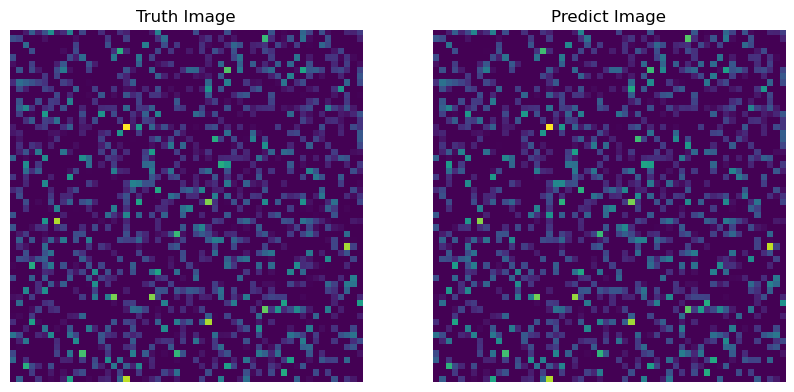

In [33]:
# 绘制灰度图
import matplotlib.pyplot as plt


# 创建一个 1x2 的子图布局
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 绘制第一个灰度图aim_of_truth(56*56)
axes[0].imshow(aim_of_truth)
axes[0].set_title('Truth Image')
axes[0].axis('off')  # 隐藏坐标轴

# 绘制第二个灰度图v_array(56*56)
axes[1].imshow(v_array)
axes[1].set_title('Predict Image')
axes[1].axis('off')  # 隐藏坐标轴

# 显示图像
plt.show()

In [35]:
# 计算误差
error = [i - j for i, j in zip(aim_of_truth, v_array)]
print(len(error))

56


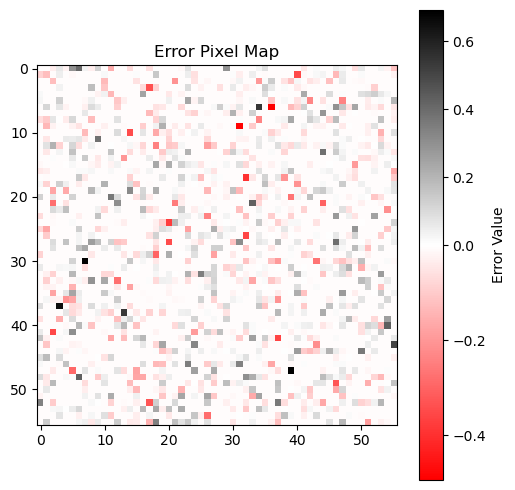

In [40]:
import matplotlib.colors as mcolors
Error_pixel_map = error

cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['red', 'white', 'black'])
norm = mcolors.TwoSlopeNorm(vmin=np.min(Error_pixel_map), vcenter=0, vmax=np.max(Error_pixel_map))

# 绘制误差像素图
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Error_pixel_map, cmap=cmap, norm=norm)
plt.colorbar(label='Error Value')
plt.title('Error Pixel Map')
plt.tight_layout()
plt.show()
# plt.savefig('error_map.jpg')

3136
频率最高的 bin 的范围是: (-0.039999999999999813, 0.03000000000000025)


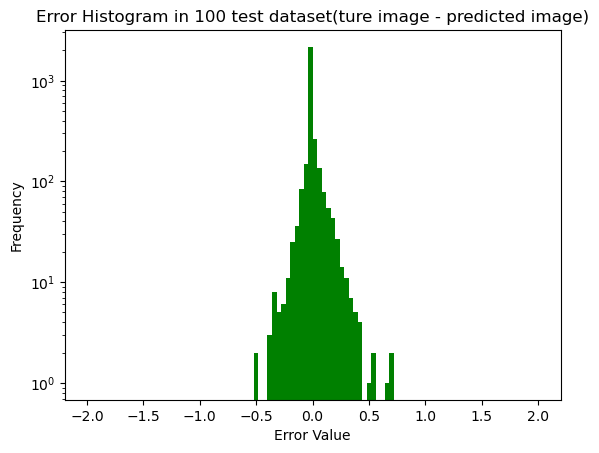

In [48]:
error_images = [item for sublist in error for item in sublist]
print(len(errors))


hist, bin_edges = np.histogram(error_images, bins=100, range=(-2, 5))
# 找到频率最高的 bin 的索引
max_bin_index = np.argmax(hist)
# 计算该 bin 的范围
max_bin_range = (bin_edges[max_bin_index], bin_edges[max_bin_index + 1])
bias = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2
print(f"频率最高的 bin 的范围是: {max_bin_range}")
# Plotting the results
plt.hist(error_images, bins=100, range=(-2, 2), histtype='stepfilled', align='mid', orientation='vertical', color='green')
plt.yscale('log')
plt.title('Error Histogram in 100 test dataset(ture image - predicted image)')
plt.xlabel('Error Value')
plt.ylabel('Frequency')
plt.savefig('error_histogram.jpg')

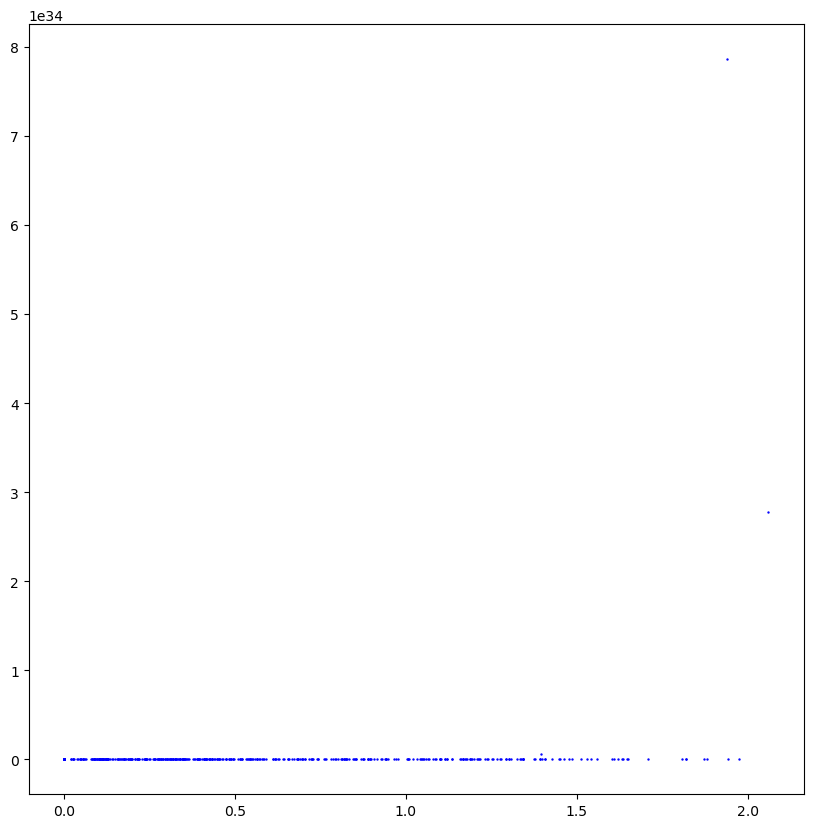

In [75]:
# outputs = np.exp(outputs)-1
# Y_test = np.exp(Y_test)-1

fig,ax1 = plt.subplots(1,1,figsize=(10,10))
ax1.plot([min(Y_test),max(Y_test)],[min(Y_test),max(Y_test)], 'k--', label='X=Y')
ax1.scatter(outputs, Y_test, s=0.5, color='blue')